# Solution of cuisine classification problem
# Shuvalov Denis 5030103/00301

## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams
rcParams['figure.figsize'] = 8.7, 5.27

# Reading and preprocessing data

In [2]:
data = pd.read_json('data.json')
data = data.rename(columns={'cuisine': 'target'})
data

,id,target,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [3]:
def preprocess_dataframe(df: pd.DataFrame):
    stops = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    texts = df['ingredients'].apply(lambda x: ' '.join(x)) # make a str
    texts = texts.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)) # delete all not valid symbols
    texts = texts.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stops]))
    texts = texts.apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])
    df['ingredients'] = texts
    return df

In [4]:
data = preprocess_dataframe(data)
data

,id,target,ingredients
0,10259,greek,"[romaine, lettuce, black, olive, grape, tomato..."
1,25693,southern_us,"[plain, flour, ground, pepper, salt, tomato, g..."
2,20130,filipino,"[egg, pepper, salt, mayonaise, cooking, oil, g..."
3,22213,indian,"[water, vegetable, oil, wheat, salt]"
4,13162,indian,"[black, pepper, shallot, cornflour, cayenne, p..."
...,...,...,...
39769,29109,irish,"[light, brown, sugar, granulated, sugar, butte..."
39770,11462,italian,"[kraft, zesty, italian, dressing, purple, onio..."
39771,2238,irish,"[egg, citrus, fruit, raisin, sourdough, starte..."
39772,41882,chinese,"[boneless, chicken, skinless, thigh, minced, g..."


In [5]:
# count every ingredient
counter = Counter()
for ingredients in data['ingredients']:
    counter.update(ingredients)

In [6]:
ingredients_count = pd.DataFrame(counter.most_common(), columns=['ingredient', 'count'])
rare_ingredients = set(ingredients_count[ingredients_count['count'] < 10]['ingredient'])
# ingredients that appears only one time are useless

In [7]:
data['ingredients'] = data['ingredients'].apply(lambda x: ' '.join([word for word in x if word not in rare_ingredients]))
data

,id,target,ingredients
0,10259,greek,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,plain flour ground pepper salt tomato ground b...
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallot cornflour cayenne pepper ...
...,...,...,...
39769,29109,irish,light brown sugar granulated sugar butter warm...
39770,11462,italian,kraft zesty italian dressing purple onion broc...
39771,2238,irish,egg citrus fruit raisin sourdough flour hot te...
39772,41882,chinese,boneless chicken skinless thigh minced garlic ...


# Data analysis and data plotting

Plotting top 10 most popular ingredients

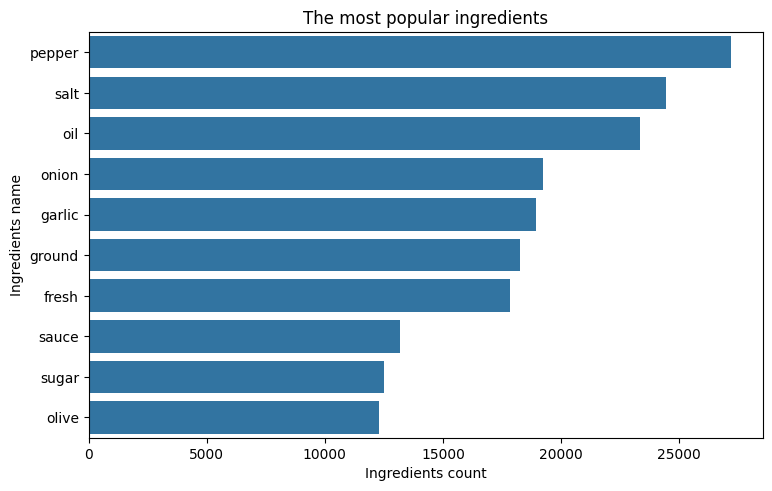

In [8]:
fig = plt.figure()
sns.barplot(pd.DataFrame(counter.most_common(10), columns=['ingredient', 'count']), x='count', y='ingredient')
plt.xlabel('Ingredients count')
plt.ylabel('Ingredients name')
plt.title('The most popular ingredients')
plt.show()

For each cuisine plotting top 10 ingridients with highest frequency

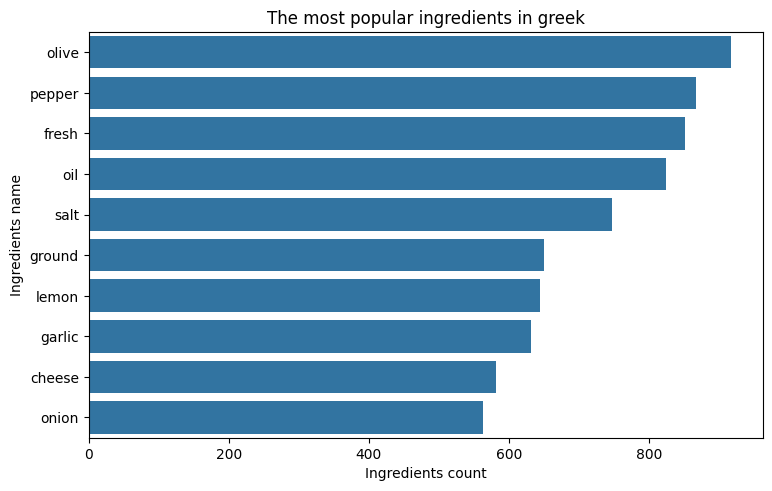

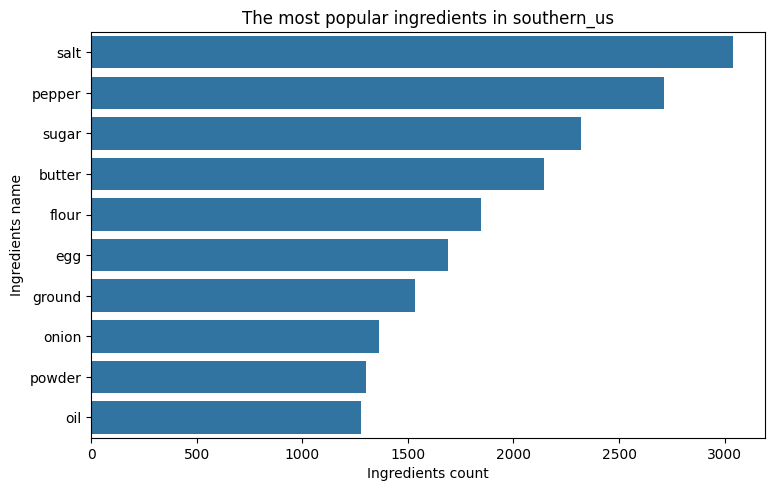

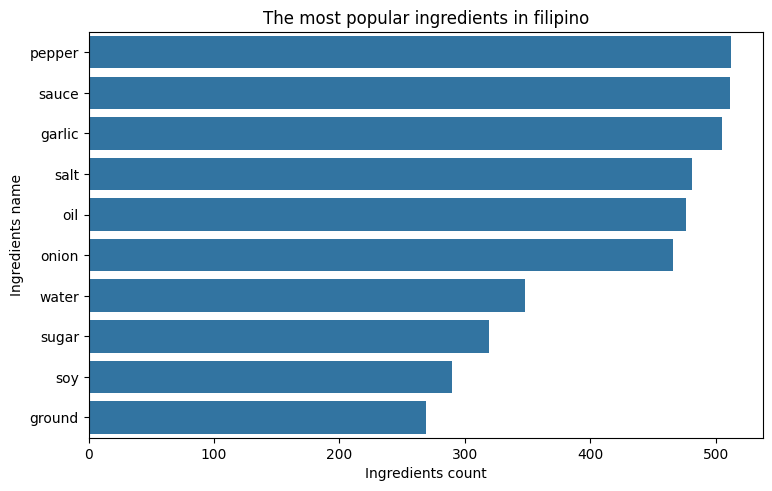

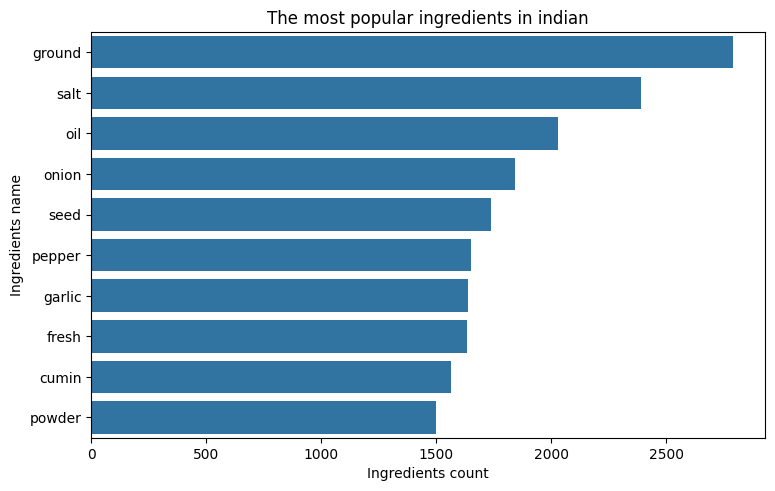

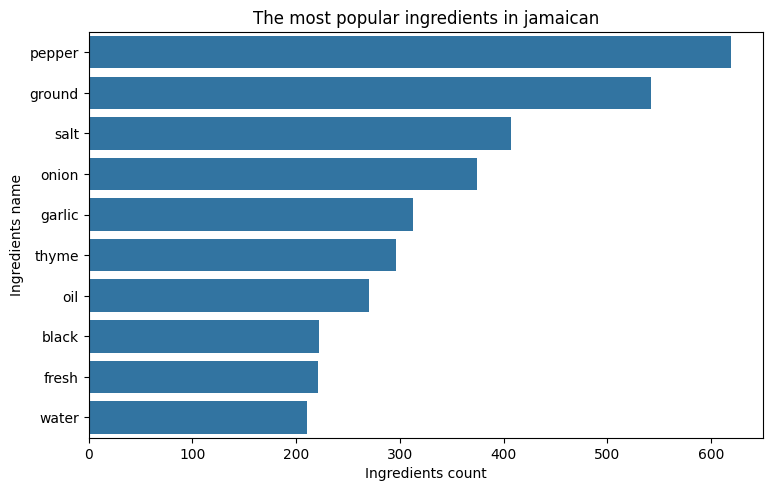

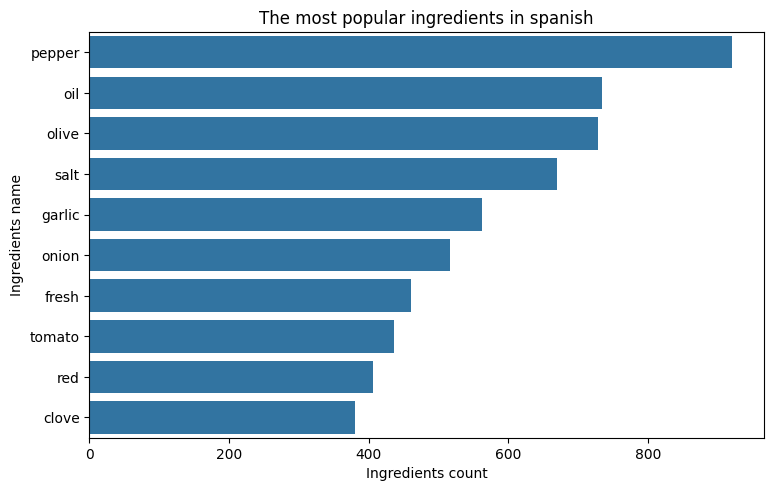

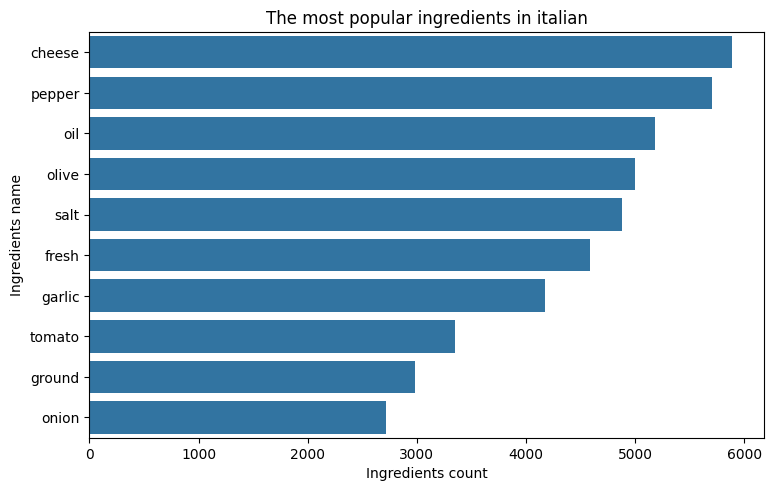

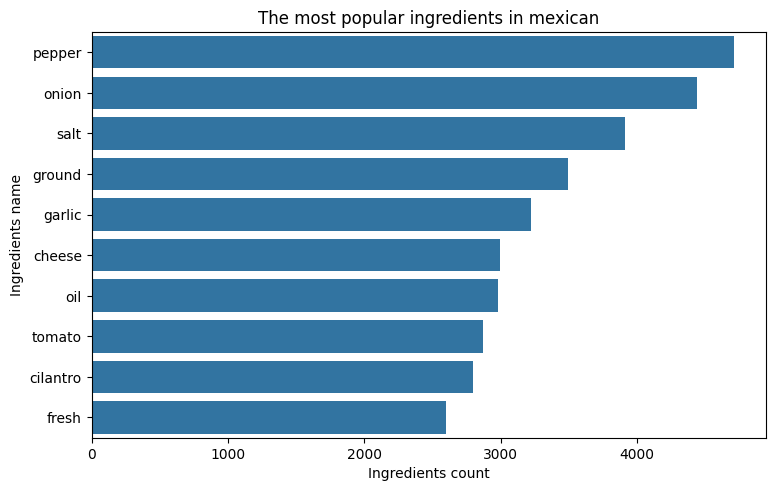

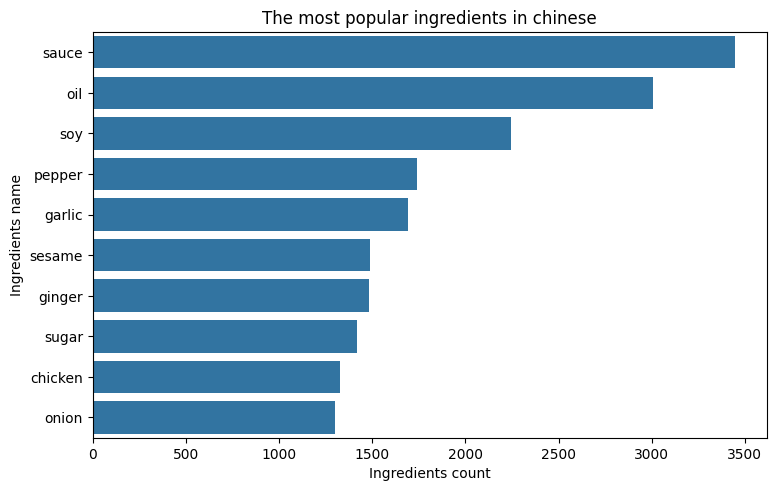

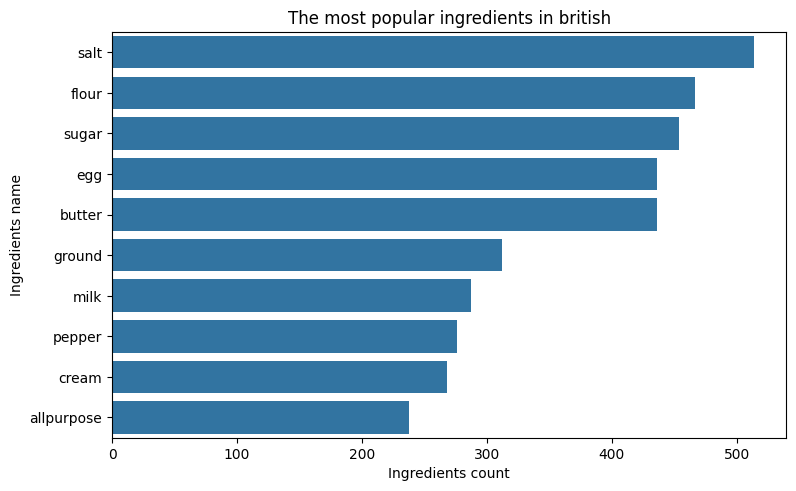

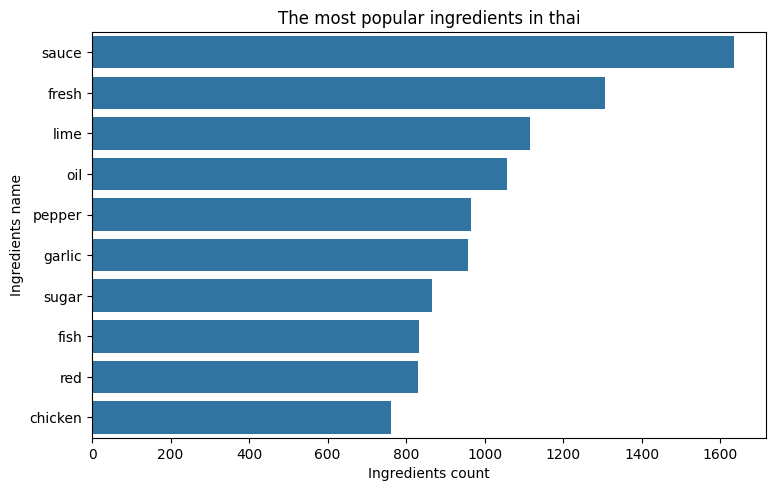

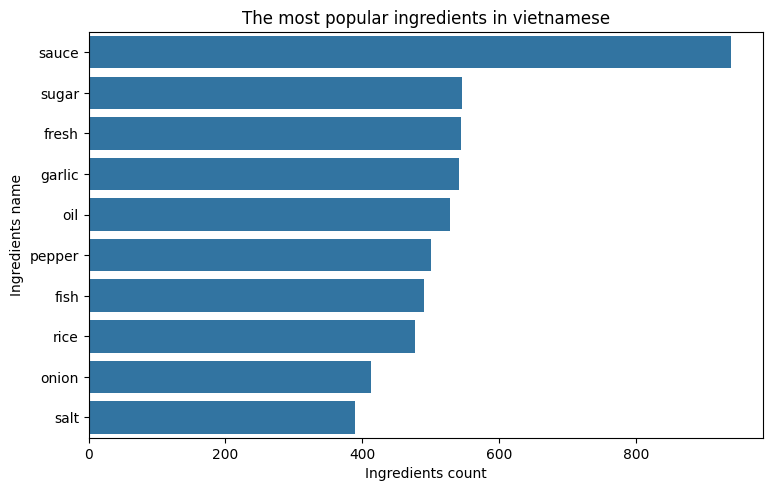

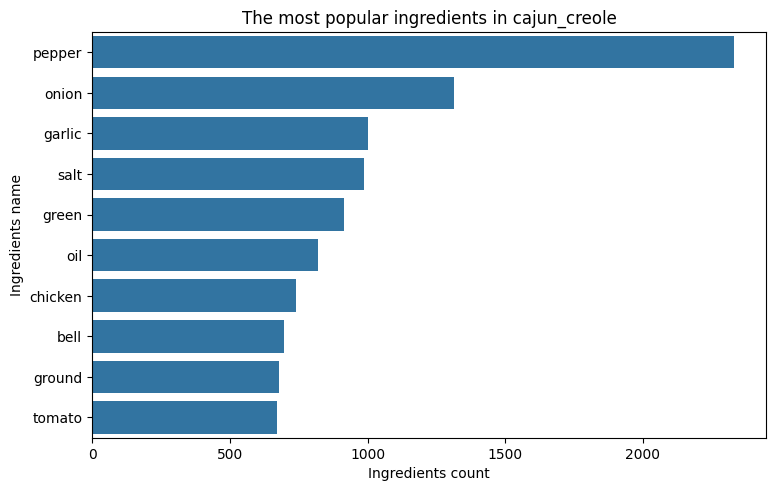

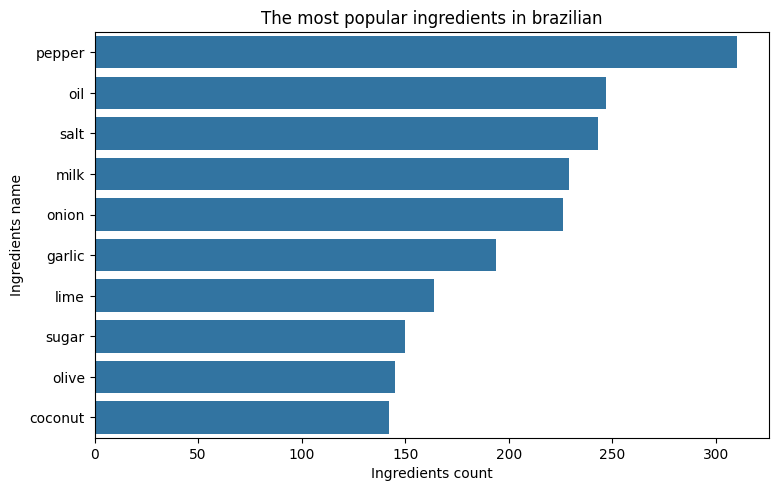

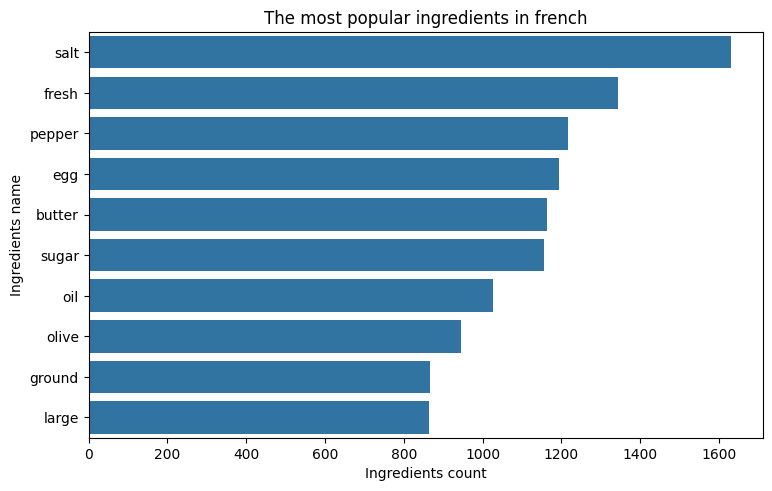

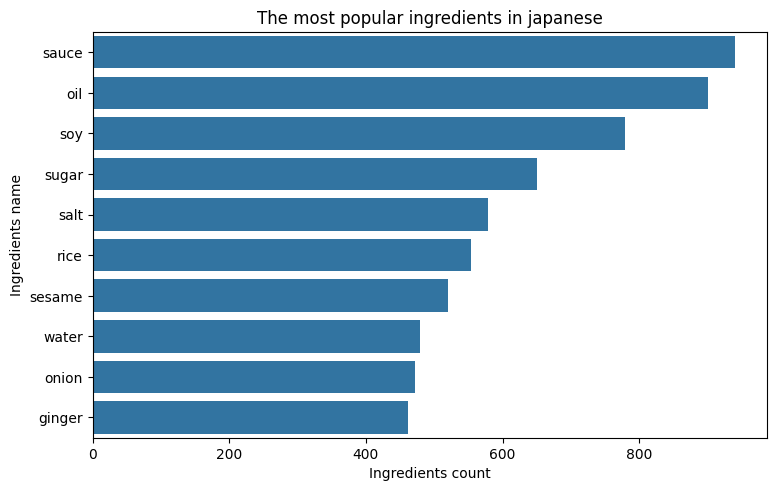

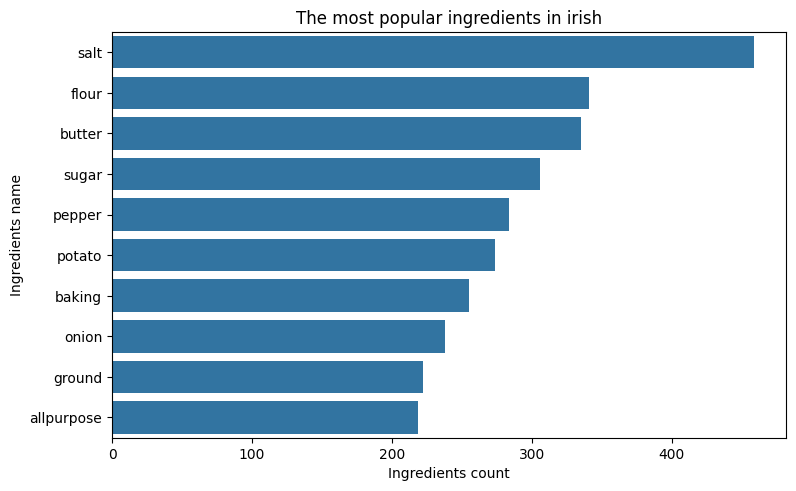

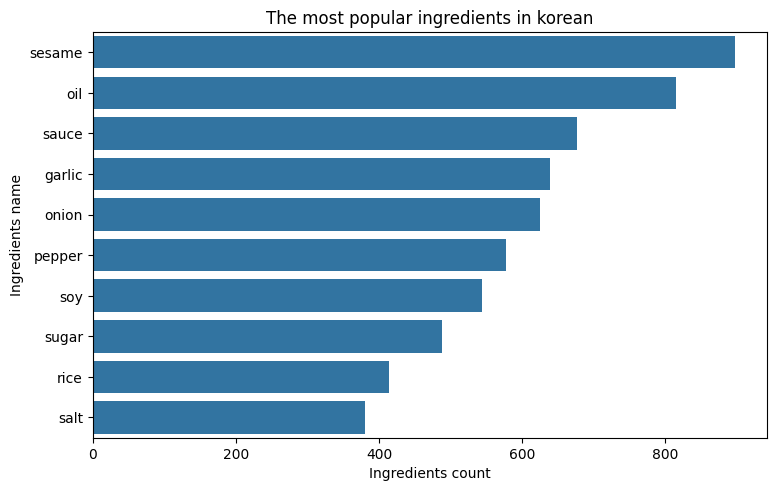

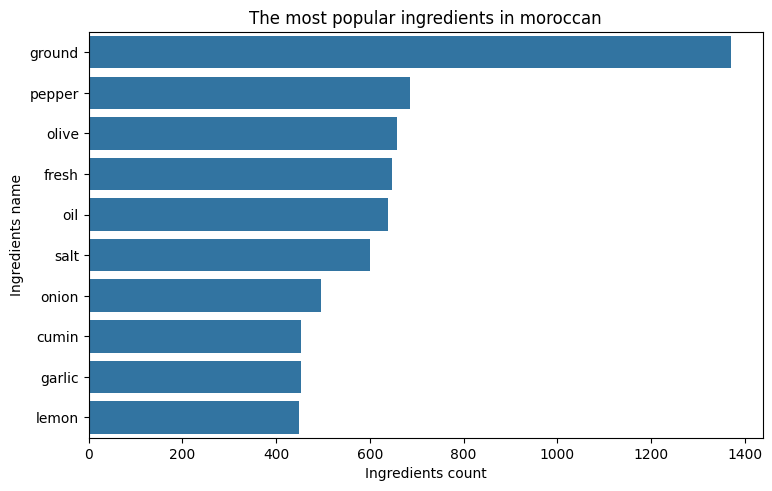

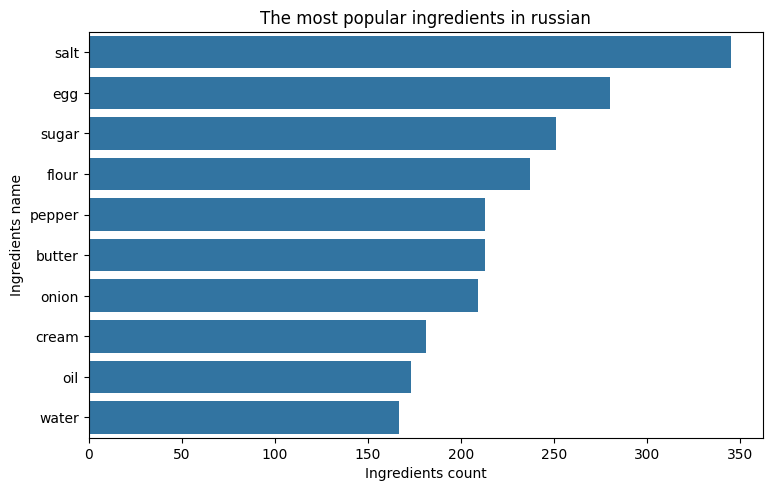

In [9]:
for cuisine_name in data['target'].unique():
    tmp_df = data[data['target'] == cuisine_name]
    counter = Counter()
    for x in tmp_df['ingredients']:
        counter.update(x.split())
    ingredients_count = pd.DataFrame(counter.most_common(10), columns=['ingredient', 'count'])
    fig = plt.figure()
    sns.barplot(ingredients_count, x='count', y='ingredient')
    plt.xlabel('Ingredients count')
    plt.ylabel('Ingredients name')
    plt.title(f'The most popular ingredients in {cuisine_name}')
    plt.show()

Also plot distribution of the number of types of cuisines in our data

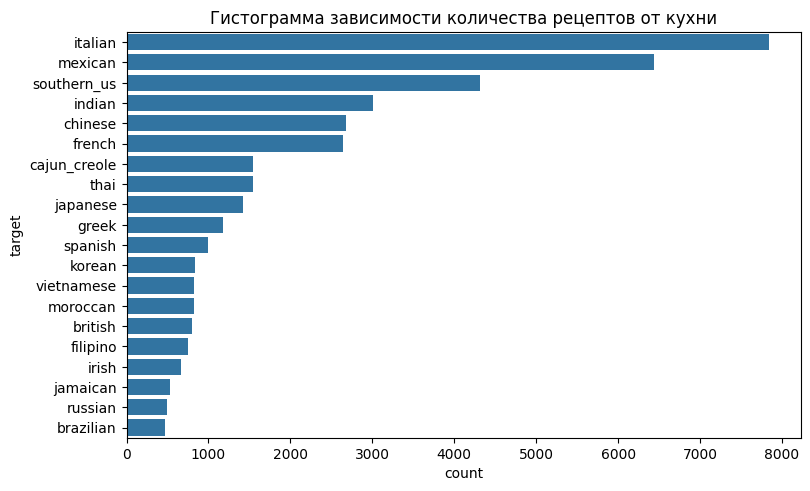

In [10]:
plt.title('Гистограмма зависимости количества рецептов от кухни')
sns.countplot(data, y='target', order=data['target'].value_counts().index);

# Selection of target and features

Use tfidf to extract features from words

In [11]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['ingredients'])
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df_tfidf = pd.concat([data, df_tfidf], axis=1)
df_tfidf

,id,target,ingredients,aai,achiote,acorn,active,added,adobo,agave,...,yoghurt,yogurt,yolk,york,yukon,zest,zesty,zinfandel,ziti,zucchini
0,10259,greek,romaine lettuce black olive grape tomato garli...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,25693,southern_us,plain flour ground pepper salt tomato ground b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,22213,indian,water vegetable oil wheat salt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,13162,indian,black pepper shallot cornflour cayenne pepper ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.196232,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,irish,light brown sugar granulated sugar butter warm...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
39770,11462,italian,kraft zesty italian dressing purple onion broc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.346433,0.0,0.0,0.0
39771,2238,irish,egg citrus fruit raisin sourdough flour hot te...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
39772,41882,chinese,boneless chicken skinless thigh minced garlic ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [12]:
target = df_tfidf['target']
categorial_features = df_tfidf.drop(columns=['target', 'id', 'ingredients'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(categorial_features,
                                                    target,
                                                    random_state=42,
                                                    test_size=0.3,
                                                    stratify=target)

# Logistic regression

In [14]:
clf_1 = LogisticRegression(n_jobs=-1)
cv = cross_val_score(clf_1, X_train, y_train, scoring='accuracy', cv=5)
print(f"Logistic regression average accuracy: {np.mean(cv):.2f}")

Logistic regression average accuracy: 0.77


In [15]:
clf_1 = LogisticRegression(n_jobs=-1)
clf_1.fit(X_train, y_train)
predictions = clf_1.predict(X_test)
print(f'Logistic Regression accuracy: {accuracy_score(predictions, y_test):.2f}')

Logistic Regression accuracy: 0.77


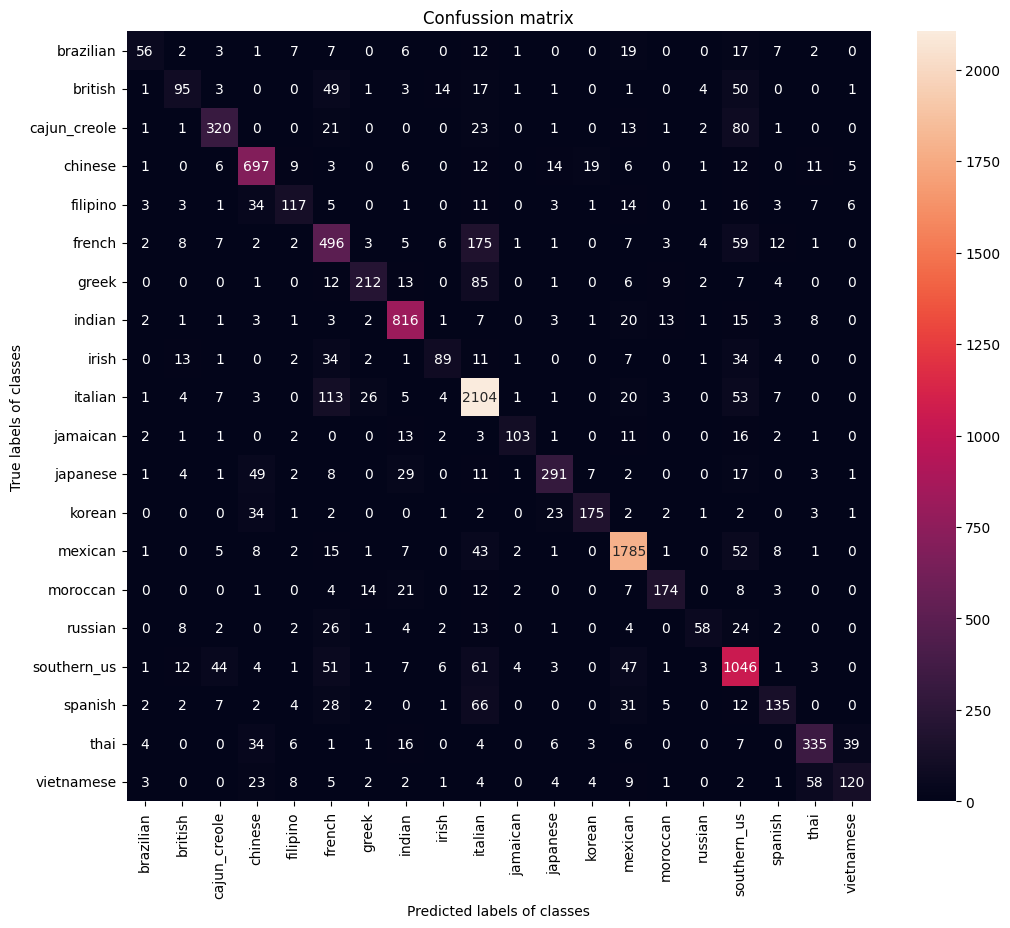

In [16]:
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels of classes')
plt.ylabel('True labels of classes')
plt.title('Confussion matrix')
plt.show()

# MultinomialNB

In [17]:
clf_2 = MultinomialNB()
cv = cross_val_score(clf_2, X_train, y_train, scoring='accuracy', cv=5)
print(f"MultinomialNB average accuracy: {np.mean(cv):.2f}")

MultinomialNB average accuracy: 0.69


In [18]:
clf_2 = MultinomialNB()
clf_2.fit(X_train, y_train)
predictions = clf_2.predict(X_test)
print(f'MultinomialNB accuracy: {accuracy_score(predictions, y_test):.2f}')

MultinomialNB accuracy: 0.70


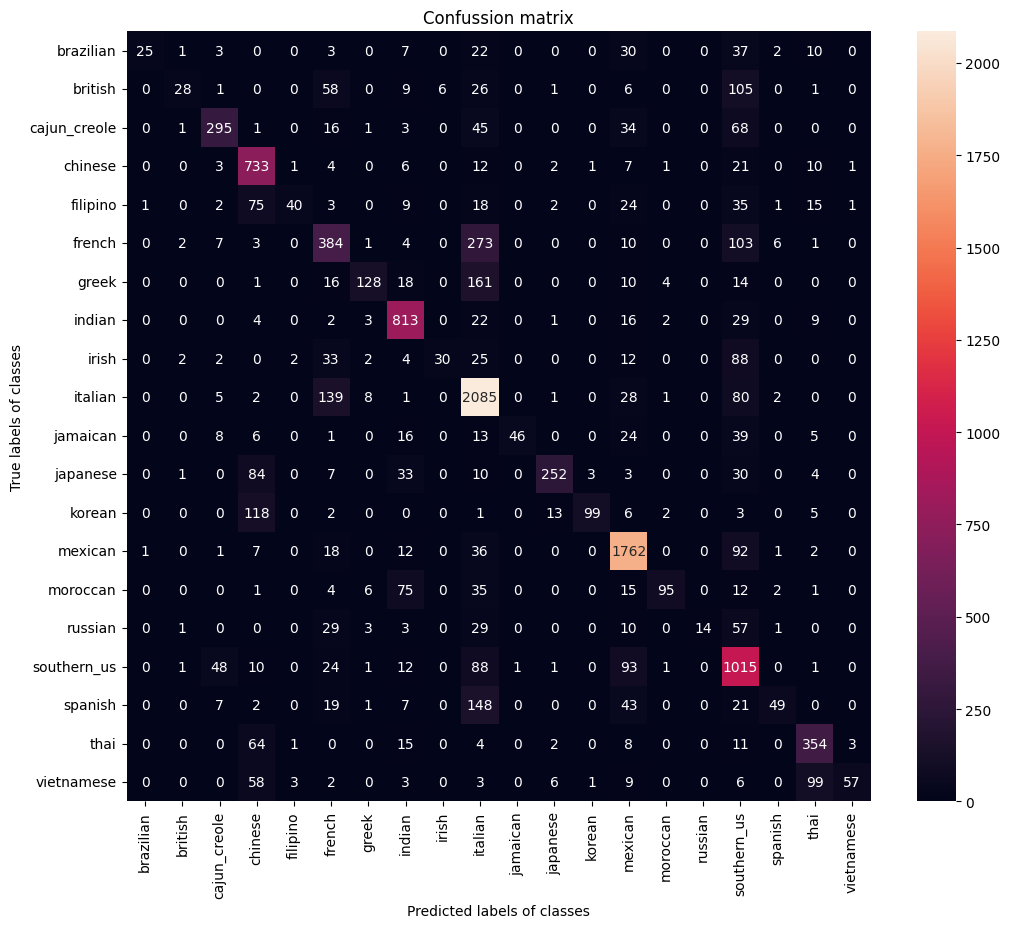

In [19]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels of classes')
plt.ylabel('True labels of classes')
plt.title('Confussion matrix')
plt.show()

# Conclusion
In this study, the task of classifying cuisines based on textual descriptions of the ingredients of dishes was considered. After preliminary processing of the text data, including the removal of irrelevant characters and stop words, lemmatization and filtering of low-frequency words to reduce the dimension of feature vectors, histograms of the distribution of the most common ingredients and the target variable were constructed. The data processed in this way was encoded using TF-IDF, after which two classification models were trained: `logistic regression` and a `naive Bayesian classifier`. The evaluation on the cross validation showed an accuracy score of `0.77` for logistic regression and `0.69` for the naive Bayesian classifier. This indicates that logistic regression is somewhat more effective in this task, which is probably due to its ability to take into account more complex relationships between ingredients and the target variable compared to the assumption of feature independence in the naive Bayesian classifier. Further research could explore more sophisticated feature processing techniques or more advanced models to potentially improve prediction accuracy.